In [1]:
from deepface import DeepFace

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

from lime import lime_image
from skimage.segmentation import mark_boundaries

In [8]:
objs = DeepFace.analyze(
  img_path = "C:/Users/Michi/Desktop/Informatik/AI Act/DeepFace/img2.jpg", 
  actions = ['age', 'gender', 'race', 'emotion'],
)

print(objs)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 90.83it/s]

[{'age': 31, 'region': {'x': 524, 'y': 201, 'w': 491, 'h': 491, 'left_eye': (858, 388), 'right_eye': (663, 390)}, 'face_confidence': 0.89, 'gender': {'Woman': 100.0, 'Man': 3.280787197468271e-06}, 'dominant_gender': 'Woman', 'race': {'asian': 0.0006865011482573565, 'indian': 0.0011724678887174882, 'black': 1.9434555746250266e-05, 'white': 98.92610901153738, 'middle eastern': 0.7335217641157963, 'latino hispanic': 0.3384911889801138}, 'dominant_race': 'white', 'emotion': {'angry': 1.138731837272644, 'disgust': 0.005745742964791134, 'fear': 41.234034299850464, 'happy': 32.78549909591675, 'sad': 6.070667877793312, 'surprise': 0.6878125015646219, 'neutral': 18.077513575553894}, 'dominant_emotion': 'fear'}]


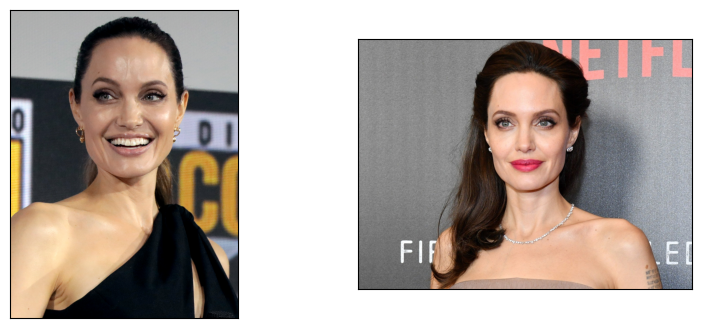

In [69]:
def get_image(path):
    with open(os.path.abspath('C:/Users/Michi/Desktop/Informatik/AI Act/DeepFace/' + path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
#get all .jpeg files in the data folder
images = [get_image(i) for i in os.listdir('C:/Users/Michi/Desktop/Informatik/AI Act/DeepFace') if i.endswith('.jpg')]
 
# plot the images
fig = plt.figure(figsize=(25, 4))
for idx, img in enumerate(images):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(img)

In [42]:
idx2label = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

In [76]:
def predict(images):
    probs_batch = []
    if len(images.shape) == 3:
        images = images[None,:] #add empty batch dimension for single image
    nr_img = images.shape[0]
    for i in range(nr_img):
        image = images[i]
        objs = DeepFace.analyze(
            img_path = image,
            actions = ['emotion'],
            enforce_detection = False)
            #actions = ['age', 'gender', 'race', 'emotion'])
        probs_dict = objs[0]["emotion"]
        probs_distr = [probs_dict["angry"]/100, probs_dict["disgust"]/100, probs_dict["fear"]/100, probs_dict["happy"]/100, probs_dict["sad"]/100, probs_dict["surprise"]/100, probs_dict["neutral"]/100]
        probs_batch.append(probs_distr)
        #plt.imshow(image)
        #plt.show()
        #print(probs_distr)
    #probs_batch = F.softmax(np.array(probs_batch), dim=1)    
    return probs_batch

In [75]:
image = np.array(images[0])
predict(image)

[[3.5220155452899817e-22,
  0.0,
  1.447645404777771e-29,
  1.0,
  1.7315110166703808e-18,
  2.4224122707749984e-11,
  3.483279087390656e-08]]

In [77]:
image = np.array(images[0])

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(image, 
                                            predict, # classification function
                                            top_labels=2, 
                                            hide_color=0, 
                                            num_samples=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [22:14<00:00,  1.33s/it]


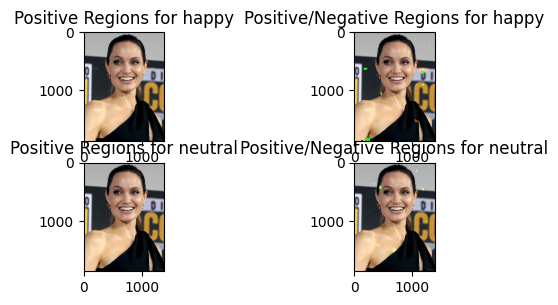

In [78]:
top_labels = 2
amt_rows = 1 + top_labels
for i in range(top_labels):
    #mask
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=True, num_features=5, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    ax = plt.subplot(amt_rows, 2, 2 + i*2 + 1)
    plt.imshow(img_boundry1)
    ax.title.set_text('Positive Regions for {}'.format(idx2label[explanation.top_labels[i]]))
    
    #mask applied to the image
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    ax = plt.subplot(amt_rows, 2, 2 + i*2 + 2)
    plt.imshow(img_boundry2)
    ax.title.set_text('Positive/Negative Regions for {}'.format(idx2label[explanation.top_labels[i]]))